# **Exploratory Analysis**


### **Motivation** 

This section serves to investigate the question: *What characterizes the companies who go bankrupt?*

By investigating this question, we can better select what information is relevant to include in our life-sentences. 

### **Outline** 

This section serves to investigate the question: *What characterizes the companies who go bankrupt?*

By investigating this question, we can better select what information is relevant to include in our life-sentences. 

Let's break down the research question into more digestable sub-questions.

**1. Counts**
- *What should our target for bankruptcies be?*
- *How many bankruptcies occur yearly in Denmark?*

*Plot 1.a*: Transition probabilities in between status codes \
*Plot 1.b*: count of bankrupt companies from 2013 to 2023 (Barchart / timeseries) \
*Plot 1.c*: Split on company types \ 


**2. Industry**
- Are some industries more susceptible to bankruptcies?

*Plot 2.a*: Number of bankruptcies split on industries per year (stacked barchart) \
*Plot 2.b*: Share of bankruptcies within the industries


**3. Company Age**
- How old are companies typically when they go bankrupt? Does it vary per industry?

*Plot 3.a*: Distribution of company age for all bankrupt companies in our subset (histogram) \
*Plot 3.b*: Same - but split on industry (most frequent industries). (histogram, colored by the industry)


**4. Financials**
- Does financial figures from annual reports indicate bankruptcy?

plot ide: scatterplot of (avg, weighted?) key1 vs key2 colored by if the company has gone bankrupt
plot ide: Choose industry, plot a time series plot annual reports keys, color lines by bankruptcy


**5. Employees**
- Employee count is a proxy for company size. Can we say something about if larger/smaller companies fail more/less?



**6. Boards** 
- experience of boards do something?



**7. Investments**
- number and size of investments



**8. Capital Changes**
- Does raised capital decrease risk of bankcruptcy?




In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path
import datetime

if Path.home().name == "nikolaibeckjensen":
    DATA_ROOT = Path.home() / "Library" / "CloudStorage" / "OneDrive-DanmarksTekniskeUniversitet" / "Virk2Vec" / "data"
elif Path.home().name == "annabramslow":
    DATA_ROOT = Path.home() / "Library" / "CloudStorage" / "OneDrive-DanmarksTekniskeUniversitet(2)" / "Virk2Vec" / "data"

## **1. Counts**

First, we find all companies that have gone bankrupt and their correspondong bankruptcy date. We define this as having reached status "Under Konkurs" or "Tvangsopløst". If a company has reached "Opløst efter konkurs" without having a date for having reached status "Under Konkurs", we will use the bankruptcy dissolution date.

In [2]:
# read all registration data
registration_folder = DATA_ROOT / "Tables" / "Registrations"
registration_files = [file for file in os.listdir(registration_folder) if file.endswith('.csv')]
registrations = pd.concat([pd.read_csv(os.path.join(registration_folder, file), index_col=0) for file in registration_files])
industries = registrations.loc[registrations.ChangeType == 'Industry']
company_types = registrations.loc[registrations.ChangeType == 'CompanyType']
registrations = registrations.loc[registrations.ChangeType == 'Status']

In [3]:
# filter status data
targets_all = ['UNDER KONKURS', "TVANGSOPLØST", "OPLØST EFTER KONKURS"]
df_all = registrations.loc[registrations.ChangeType == 'Status']
registrations_target = registrations.loc[registrations.NewValue.isin(targets_all)]

tvang_registrations = registrations_target.loc[registrations_target.NewValue.isin(["UNDER KONKURS"])][['CVR', 'FromDate', 'NewValue']]
u_konkurs_registrations = registrations_target.loc[registrations_target.NewValue.isin(["TVANGSOPLØST"])][['CVR', 'FromDate','NewValue']]

# merge the two dataframes
df_bankrupt = pd.concat([tvang_registrations, u_konkurs_registrations])
#df_bankrupt = df_bankrupt.rename(columns={'NewValue': 'bankrupt_type'})

# add the opløst efter konkurs
rest = registrations_target.loc[~registrations_target.CVR.isin(df_bankrupt.CVR)]
rest = rest.loc[rest.NewValue.isin(["OPLØST EFTER KONKURS"])]

# add the rest to the df_bankrupt
df_bankrupt_temp = pd.concat([df_bankrupt, rest[['CVR', 'FromDate', 'NewValue']]]).rename(columns={'FromDate': 'bankrupt_date'})

#group by CVR and get the earliest date for cases where a company has both 'tvangsopløst' and 'under konkurs'
df_bankrupt = df_bankrupt_temp.groupby('CVR').agg({'bankrupt_date': 'min'}).reset_index()

#join bankrupt type back to the df_bankrupt
df_bankrupt = df_bankrupt.merge(df_bankrupt_temp, on=['CVR', 'bankrupt_date'], how='left')

# correct df_all to not include the companies that are bankrupt
df_all = df_all.loc[~df_all.CVR.isin(df_bankrupt.CVR)][['CVR', 'FromDate']]

In [23]:
#groupby make newvalue a list
df_list = registrations.groupby('CVR').NewValue.apply(list)
status_changes = df_list.tolist()
status_changes = [status_change + ["-->NO FURTHER CHANGEs<--"] for status_change in status_changes]

### 1.a Understanding the Transition Probabilities for Company Status

In [24]:
#status_types = ["NORMAL"] + bankrupt_types + distress_types
status_types = registrations.NewValue.value_counts(normalize=True).index[:14].tolist() + ["-->NO FURTHER CHANGEs<--"]
#status_types = registrations.NewValue.value_counts(normalize=True).index.tolist() + ["-->NO FURTHER CHANGEs<--"]

all_combinations = []
for status in status_types:
    for status2 in status_types:
        all_combinations.append((status, status2))

def transition_count(status_changes, key1, key2):
    transition_count = sum(
        1 for status_list in status_changes
        for i in range(len(status_list) - 1)
        if status_list[i] == key1 and status_list[i + 1] == key2
    )
    return transition_count

# create a matrix of status changes
status_matrix = np.zeros((len(status_types), len(status_types)))
for i, status1 in enumerate(status_types):
    for j, status2 in enumerate(status_types):
        status_matrix[i, j] = transition_count(status_changes, status1, status2)

# compute the transition probabilities
transition_probabilities = status_matrix / status_matrix.sum(axis=1, keepdims=True)


/var/folders/18/tx_vvd811j166hznznnvx7sm0000gn/T/ipykernel_67789/1776791151.py:25: RuntimeWarning: invalid value encountered in divide
  transition_probabilities = status_matrix / status_matrix.sum(axis=1, keepdims=True)


Text(0.5, 1.0, 'Status transition matrix')

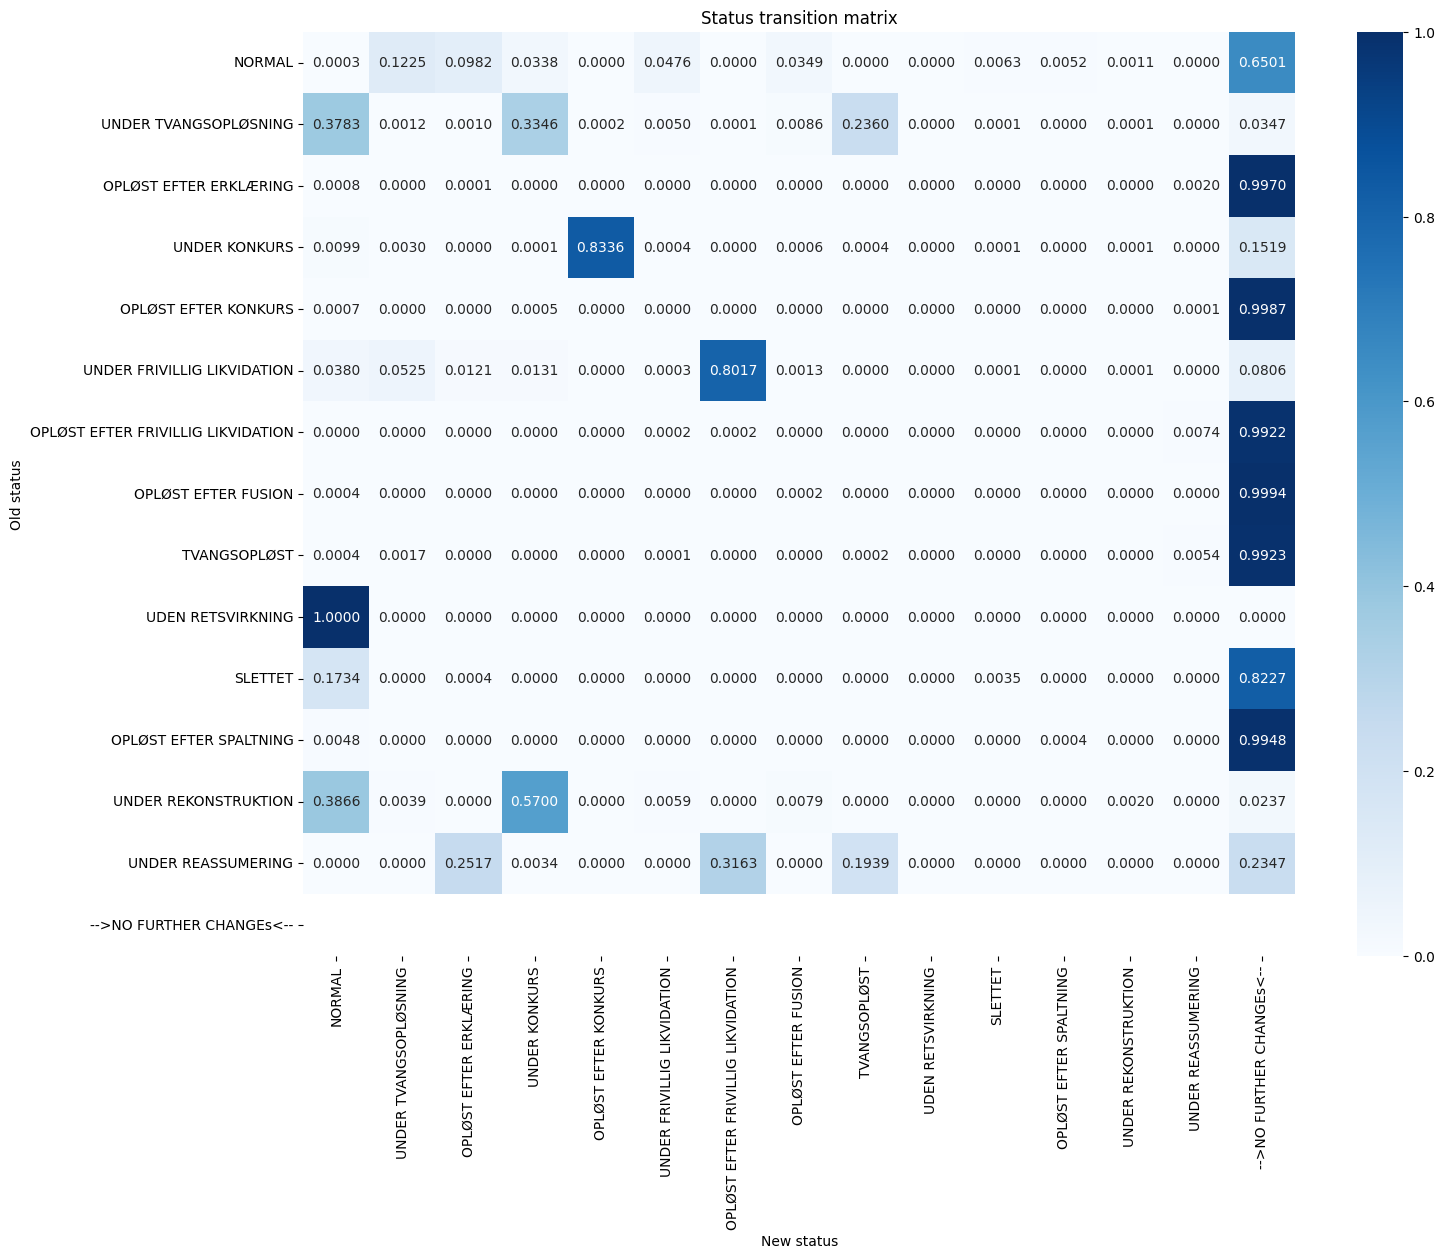

In [25]:
# plot the matrix using seaborn
plt.figure(figsize=(16, 12))
sns.heatmap(transition_probabilities, annot=True, xticklabels=status_types, yticklabels=status_types, fmt=".4f", cmap="Blues")
plt.xlabel('New status')
plt.ylabel('Old status')
plt.title('Status transition matrix')

Filter CVR numbers - only include companies that at some point has been IVS, A/S or ApS

In [7]:
#cvr filter file
cvr_filter = DATA_ROOT / "Tables" / "CVRFiltered"
cvr_filter_files = [file for file in os.listdir(cvr_filter) if file.endswith('.csv')]
cvr_filter = pd.concat([pd.read_csv(os.path.join(cvr_filter, file), index_col=0) for file in cvr_filter_files])

In [9]:
registrations_filtered = registrations.loc[registrations.CVR.isin(cvr_filter.CVR)]

In [13]:
# creat year column but cutting first 4 characters from FromDate
registrations_filtered['year'] = registrations_filtered.FromDate.str[:4]

/var/folders/18/tx_vvd811j166hznznnvx7sm0000gn/T/ipykernel_67789/3577651215.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  registrations_filtered['year'] = registrations_filtered.FromDate.str[:4]


In [17]:
#drop rows with nan year and convert year to int
registrations_filtered = registrations_filtered.dropna(subset=['year'])

registrations_filtered['year'] = registrations_filtered['year'].astype(int)

In [19]:
registrations_filtered.NewValue.value_counts()

NewValue
NORMAL                                                433286
UNDER TVANGSOPLØSNING                                  55336
OPLØST EFTER ERKLÆRING                                 43772
UNDER KONKURS                                          33962
OPLØST EFTER KONKURS                                   28332
UNDER FRIVILLIG LIKVIDATION                            20960
OPLØST EFTER FRIVILLIG LIKVIDATION                     16897
OPLØST EFTER FUSION                                    15841
TVANGSOPLØST                                           13135
UDEN RETSVIRKNING                                       7436
OPLØST EFTER SPALTNING                                  2304
UNDER REKONSTRUKTION                                     501
UNDER REASSUMERING                                       288
OPLØST EFTER GRÆNSEOVERSKRIDENDE FUSION                   43
OPLØST EFTER GRÆNSEOVERSKRIDENDE HJEMSTEDSFLYTNING        30
SLETTET                                                    9
Under reassumer

### 1.b Bankruptcies by Year

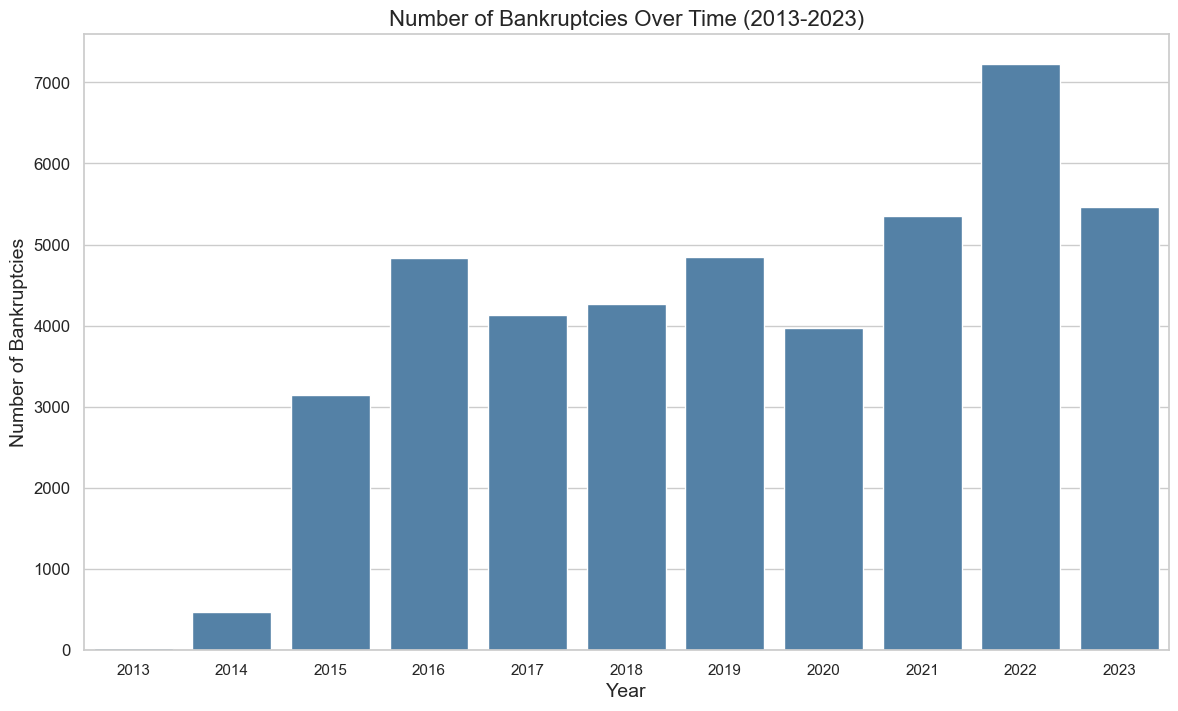

In [8]:
# Prepare the data
df_bankrupt = df_bankrupt.rename(columns={'NewValue': 'bankrupt_type'})
df_bankrupt['bankrupt_date'] = pd.to_datetime(df_bankrupt['bankrupt_date'])
df_bankrupt['year'] = df_bankrupt['bankrupt_date'].dt.year
df_bankrupt_hist = df_bankrupt.loc[(df_bankrupt.year >= 2013)&(df_bankrupt.year <= 2023)]

# Create a new dataframe for plotting
bankruptcy_counts = df_bankrupt_hist.groupby('year').size().reset_index(name='count')

# Set up the figure with seaborn styling
sns.set(style='whitegrid')
plt.figure(figsize=(14, 8))

# Create a bar plot
sns.barplot(data=bankruptcy_counts, x='year', y='count', color='steelblue')

# Set titles and labels
plt.title('Number of Bankruptcies Over Time (2013-2023)', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Number of Bankruptcies', fontsize=14)

# Adjust tick parameters
plt.yticks(fontsize=12)
plt.show()


In [9]:
df_bankrupt.loc[df_bankrupt.year < 2013]

,CVR,bankrupt_date,bankrupt_type,year
46,10042011,2011-03-02,UNDER KONKURS,2011
249,10279291,1990-03-29,UNDER KONKURS,1990
351,10690609,1987-09-21,UNDER KONKURS,1987
396,11091091,2011-02-23,UNDER KONKURS,2011
421,11525989,1993-11-24,UNDER KONKURS,1993
...,...,...,...,...
46857,78282215,1991-07-19,UNDER KONKURS,1991
46893,79203211,2006-01-05,UNDER KONKURS,2006
46929,81693110,1990-04-10,TVANGSOPLØST,1990
46935,81828016,1994-06-14,UNDER KONKURS,1994


### 1.c Bankruptcies across Years by Ccompany Type

In [10]:
#convert company types to datetime
company_types['FromDate'] = pd.to_datetime(company_types['FromDate'])

#sort the dataframes
df_bankrupt_hist = df_bankrupt_hist.sort_values('bankrupt_date')
company_types = company_types.sort_values('FromDate')

#create a merge as of to get the company type at the time of bankruptcy
df_bank_comp = pd.merge_asof(df_bankrupt_hist, company_types, left_on='bankrupt_date', right_on='FromDate', by='CVR',direction='nearest')
#drop and rename columns
df_bank_comp = df_bank_comp.drop(columns=['FromDate', 'ChangeType']).rename(columns={'NewValue': 'company_type'})

In [11]:
# Define a fixed color library for the company types using sns Set2 palette
color_palette = sns.color_palette("Set3", n_colors=10)

color_library = {
    'I/S': color_palette[0],  # First color in Set2
    'EFO': color_palette[1],  # Second color in Set2
    'A/S': color_palette[2],  # Third color in Set2
    'IVS': color_palette[3],  # Fourth color in Set2
    'APS': color_palette[4],  # Fifth color in Set2
    'ABA': color_palette[5],  # Sixth color in Set2
    'KAS': color_palette[6],  # Seventh color in Set2
    'FMA': color_palette[7],  # Eighth color in Set2
    'K/S': color_palette[8],  # Ninth color in Set2
    'SMA': color_palette[9],  # Tenth color in Set2
}

<Figure size 3000x2000 with 0 Axes>

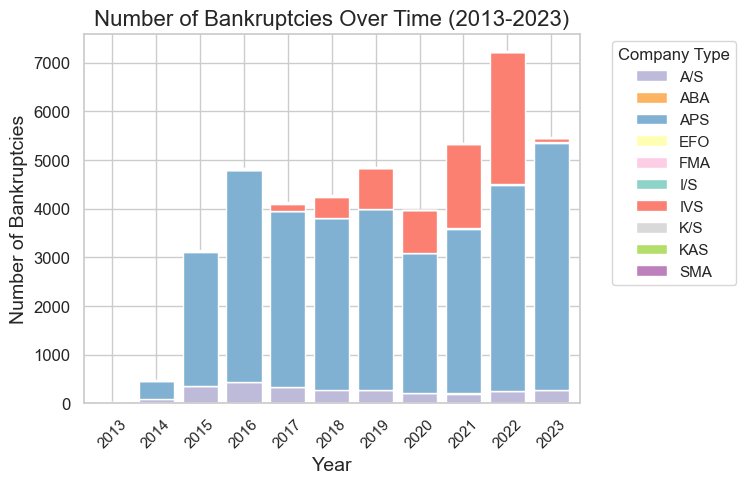

In [12]:
# Create a pivot table to get counts of each company type per year
stacked_data = df_bank_comp.pivot_table(index='year', columns='company_type', aggfunc='size', fill_value=0)

# Match the color library with the company types in the dataset
colors = [color_library.get(c, '#1f77b4') for c in stacked_data.columns]

# Plot as a stacked bar chart
plt.figure(figsize=(30, 20))
ax = stacked_data.plot(kind='bar', stacked=True, color=colors, width=0.8)

# Set titles and labels
plt.title('Number of Bankruptcies Over Time (2013-2023)', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Number of Bankruptcies', fontsize=14)
plt.xticks(rotation=45)
plt.yticks(fontsize=12)

# Move the legend outside the plot
plt.legend(title='Company Type', bbox_to_anchor=(1.05, 1), loc='upper left')
#plt.tight_layout()  # Adjust layout to make room for the legend
plt.show()

<Figure size 3000x2000 with 0 Axes>

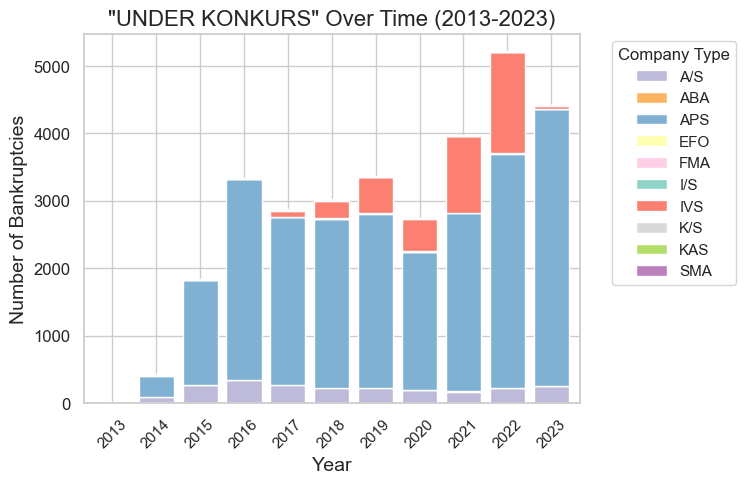

In [13]:
# Create a pivot table to get counts of each company type per year
stacked_data_u_konk = df_bank_comp.loc[df_bank_comp.bankrupt_type == 'UNDER KONKURS'].pivot_table(index='year', columns='company_type', aggfunc='size', fill_value=0)

# Match the color library with the company types in the dataset
colors = [color_library.get(c, '#1f77b4') for c in stacked_data_u_konk.columns]

# Plot as a stacked bar chart
plt.figure(figsize=(30, 20))
ax = stacked_data_u_konk.plot(kind='bar', stacked=True, color=colors, width=0.8)

# Set titles and labels
plt.title('"UNDER KONKURS" Over Time (2013-2023)', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Number of Bankruptcies', fontsize=14)
plt.xticks(rotation=45)
plt.yticks(fontsize=12)

# Move the legend outside the plot
plt.legend(title='Company Type', bbox_to_anchor=(1.05, 1), loc='upper left')
#plt.tight_layout()  # Adjust layout to make room for the legend
plt.show()

<Figure size 3000x2000 with 0 Axes>

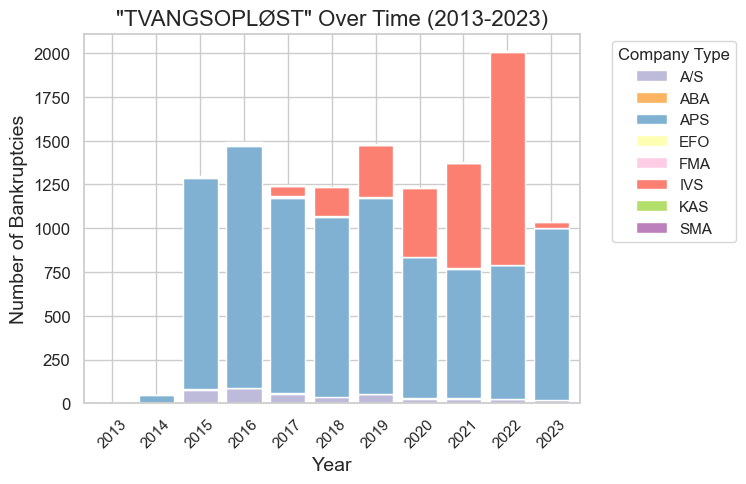

In [14]:
# Create a pivot table to get counts of each company type per year
stacked_data_tvang = df_bank_comp.loc[df_bank_comp.bankrupt_type == 'TVANGSOPLØST'].pivot_table(index='year', columns='company_type', aggfunc='size', fill_value=0)

# Match the color library with the company types in the dataset
colors = [color_library.get(c, '#1f77b4') for c in stacked_data_tvang.columns]

# Plot as a stacked bar chart
plt.figure(figsize=(30, 20))
ax = stacked_data_tvang.plot(kind='bar', stacked=True, color=colors, width=0.8)

# Set titles and labels
plt.title('"TVANGSOPLØST" Over Time (2013-2023)', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Number of Bankruptcies', fontsize=14)
plt.xticks(rotation=45)
plt.yticks(fontsize=12)

# Move the legend outside the plot
plt.legend(title='Company Type', bbox_to_anchor=(1.05, 1), loc='upper left')
#plt.tight_layout()  # Adjust layout to make room for the legend
plt.show()

## **2. Industry**

### 2.a Bankrupties by Industry

In [15]:
#convert industries date to datetime
industries['FromDate'] = pd.to_datetime(industries['FromDate'])

#sort the dataframes
df_bankrupt_hist = df_bankrupt_hist.sort_values('bankrupt_date')
industries = industries.sort_values('FromDate')

#create a merge as of to get the company type at the time of bankruptcy
df_bank_indu = pd.merge_asof(df_bankrupt_hist, industries, left_on='bankrupt_date', right_on='FromDate', by='CVR',direction='nearest')
#drop and rename columns
df_bank_indu = df_bank_indu.drop(columns=['FromDate', 'ChangeType']).rename(columns={'NewValue': 'industry_code'})

In [16]:
#create categories for the industries

industry_dict = {1: 'Landbrug, skovbrug og fiskeri',
                    2: 'Industri, råstofindvinding og forsyningsvirksomhed',
                    3: 'Bygge og anlæg',
                    4: 'Handel og transport',
                    5: 'Information og kommunikation',
                    6: 'Finansiering og forsikring',
                    7: 'Ejendomshandel og udlejning',
                    8: 'Erhvervsservice',
                    9: 'Offentlig administration, undervisning og sundhed',
                    10: 'Kultur, fritid og anden service',
                    11: 'Uoplyst aktiviteter'}

def compute_industry_category(industry_code):
    if int(industry_code[:2]) < 5:
        return 1
    elif int(industry_code[:2]) < 41:
        return 2
    elif int(industry_code[:2]) < 45:
        return 3
    elif int(industry_code[:2]) < 58:
        return 4
    elif int(industry_code[:2]) < 64:
        return 5
    elif int(industry_code[:2]) < 68:
        return 6
    elif int(industry_code[:2]) < 69:
        return 7
    elif int(industry_code[:2]) < 84:
        return 8
    elif int(industry_code[:2]) < 99:
        return 9
    elif int(industry_code[:2]) <= 99 and industry_code != 999999:
        return 10
    else:
        return 11

In [17]:
#map industry code to industry category
df_bank_indu['short_industry_code'] = df_bank_indu['industry_code'].apply(lambda x: compute_industry_category(x))

<Figure size 3000x2000 with 0 Axes>

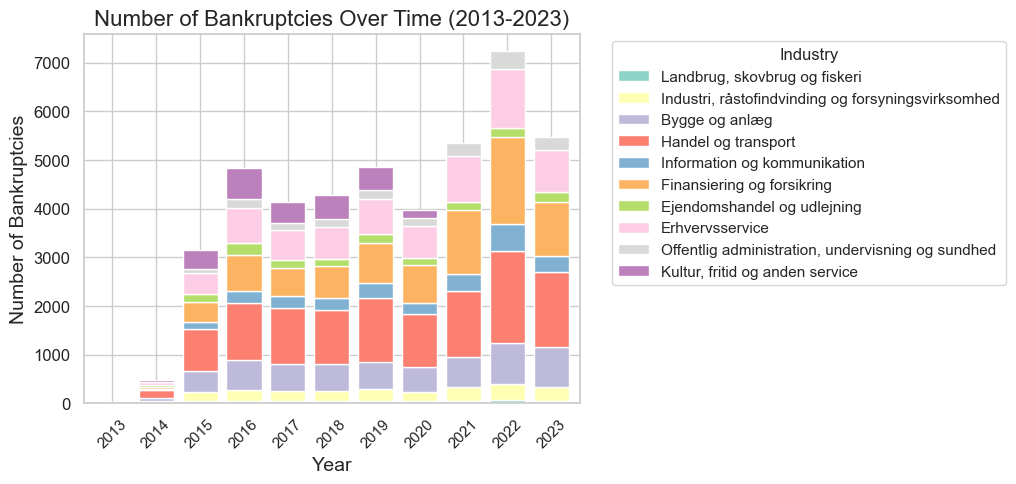

In [18]:
# Create a pivot table to get counts of each company type per year
stacked_data = df_bank_indu.pivot_table(index='year', columns='short_industry_code', aggfunc='size', fill_value=0)

# Match the color library with the company types in the dataset
#colors = [color_library.get(c, '#1f77b4') for c in stacked_data.columns]

# Plot as a stacked bar chart
plt.figure(figsize=(30, 20))
ax = stacked_data.plot(kind='bar', stacked=True, color=sns.color_palette("Set3"), width=0.8)

# Set titles and labels
plt.title('Number of Bankruptcies Over Time (2013-2023)', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Number of Bankruptcies', fontsize=14)
plt.xticks(rotation=45)
plt.yticks(fontsize=12)

# Move the legend outside the plot
# use industry_dict to get the industry names
plt.legend(title='Industry', labels=[industry_dict.get(i, 'Unknown') for i in stacked_data.columns], bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

<Figure size 3000x2000 with 0 Axes>

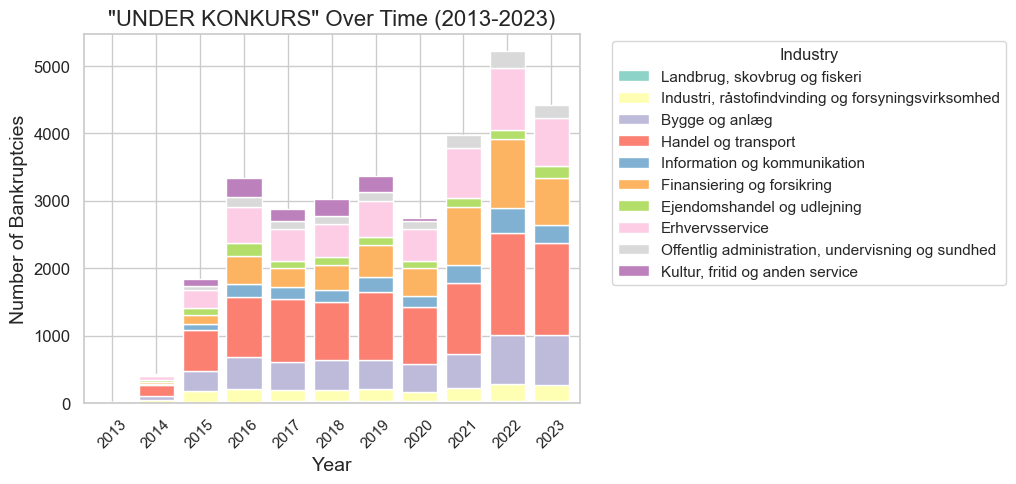

In [19]:
# Create a pivot table to get counts of each company type per year
stacked_data_u_konk = df_bank_indu.loc[df_bank_indu.bankrupt_type == 'UNDER KONKURS'].pivot_table(index='year', columns='short_industry_code', aggfunc='size', fill_value=0)

# Match the color library with the company types in the dataset
#colors = [color_library.get(c, '#1f77b4') for c in stacked_data.columns]

# Plot as a stacked bar chart
plt.figure(figsize=(30, 20))
ax = stacked_data_u_konk.plot(kind='bar', stacked=True, color=sns.color_palette("Set3"), width=0.8)

# Set titles and labels
plt.title('"UNDER KONKURS" Over Time (2013-2023)', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Number of Bankruptcies', fontsize=14)
plt.xticks(rotation=45)
plt.yticks(fontsize=12)

# Move the legend outside the plot
# use industry_dict to get the industry names
plt.legend(title='Industry', labels=[industry_dict.get(i, 'Unknown') for i in stacked_data_u_konk.columns], bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

<Figure size 3000x2000 with 0 Axes>

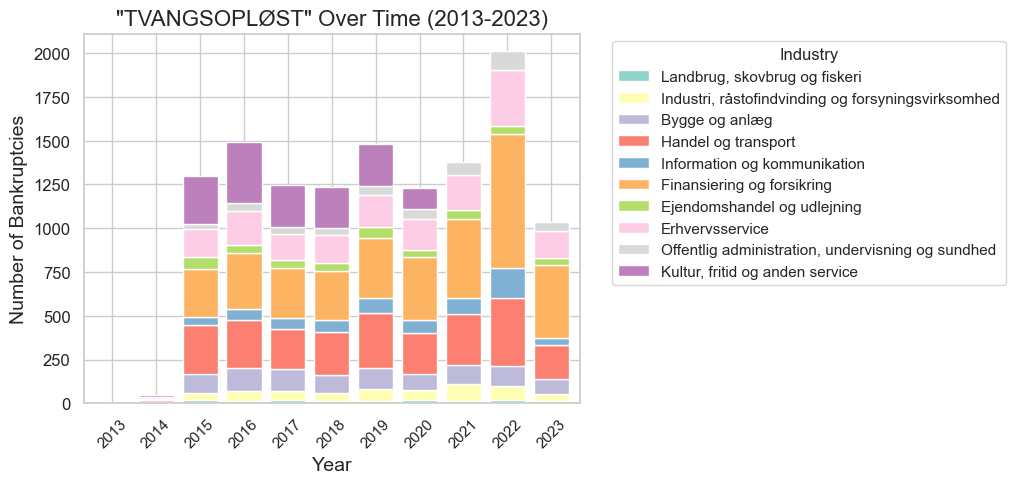

In [20]:
# Create a pivot table to get counts of each company type per year
stacked_data_tvang = df_bank_indu.loc[df_bank_indu.bankrupt_type == 'TVANGSOPLØST'].pivot_table(index='year', columns='short_industry_code', aggfunc='size', fill_value=0)

# Match the color library with the company types in the dataset
#colors = [color_library.get(c, '#1f77b4') for c in stacked_data.columns]

# Plot as a stacked bar chart
plt.figure(figsize=(30, 20))
ax = stacked_data_tvang.plot(kind='bar', stacked=True, color=sns.color_palette("Set3"), width=0.8)

# Set titles and labels
plt.title('"TVANGSOPLØST" Over Time (2013-2023)', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Number of Bankruptcies', fontsize=14)
plt.xticks(rotation=45)
plt.yticks(fontsize=12)

# Move the legend outside the plot
# use industry_dict to get the industry names
plt.legend(title='Industry', labels=[industry_dict.get(i, 'Unknown') for i in stacked_data_tvang.columns], bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

1: Landbrug, skovbrug og fiskeri

2: Industri, råstofindvinding og forsyningsvirksomhed

3: Bygge og anlæg

4: Handel og transport

5: Information og kommunikation

6: Finansiering og forsikring

7: Ejendomshandel og udlejning

8: Erhvervsservice

9: Offentlig administration, undervisning og sundhed

10: Kultur, fritid og anden service

11: Uoplyst aktiviteter

(some issues with cutting industry code down to 1 digit, includes cross over between categories)

### 2.b Bankruptcy share within Industry

In [21]:
#if fromdate is nan then fill with 2000-01-01
df_all['FromDate'] = df_all['FromDate'].fillna('2000-01-01')

#groupby CVR and get the latest date
df_alive = df_all.groupby('CVR').agg({'FromDate': 'max'}).reset_index()

In [22]:
#convert dates to datetime
df_alive['FromDate'] = pd.to_datetime(df_alive['FromDate'])

#sort the dataframes
df_alive = df_alive.sort_values('FromDate')
industries = industries.sort_values('FromDate')

#create a merge as of to get the industry code at the latest status
df_alive_indu = pd.merge_asof(df_alive, industries, left_on='FromDate', right_on='FromDate', by='CVR',direction='nearest')
df_alive_indu = df_alive_indu.drop(columns=['ChangeType']).rename(columns={'NewValue': 'industry_code'})

#convert industry code to only the first digit
df_alive_indu['short_industry_code'] = df_alive_indu['industry_code'].apply(lambda x: compute_industry_category(x))

In [23]:
#stack df_alive_indu with df_bank_indu
df_alive_indu = df_alive_indu.rename(columns={'FromDate': 'Date'})
df_alive_indu['status'] = 'ALIVE'
df_dead_indu = df_bank_indu.rename(columns={'bankrupt_date': 'Date'})[['CVR', 'Date', 'industry_code', 'short_industry_code']]
df_dead_indu['status'] = 'DEAD'

df_combined = pd.concat([df_alive_indu, df_dead_indu])


In [24]:
#for every industry code, compute the share of companies that are dead
df_industry = df_combined.groupby(['short_industry_code', 'status']).size().unstack().reset_index()
df_industry['total'] = df_industry['ALIVE'] + df_industry['DEAD']
df_industry['dead_share'] = df_industry['DEAD'] / df_industry['total']

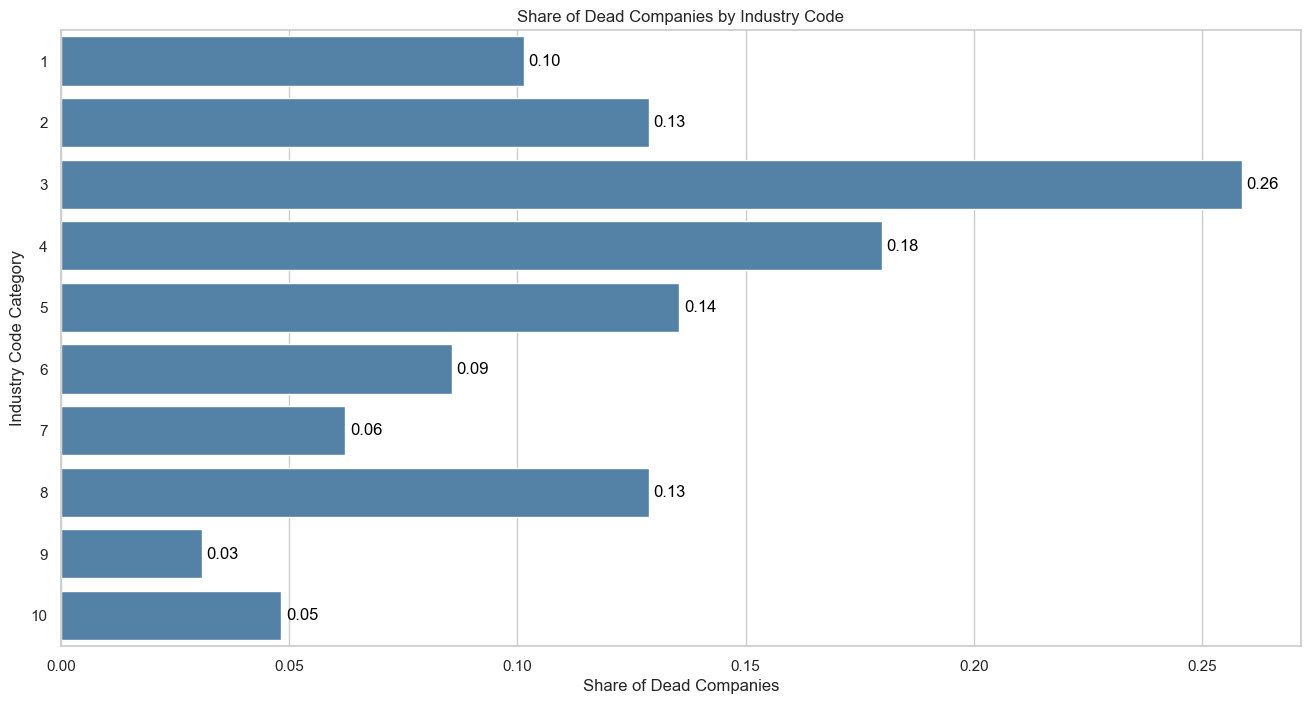

In [25]:
# Sort the data by 'industry_code' if you want the y-axis sorted by industry code
df_sorted = df_industry.sort_values('short_industry_code')
#turn short industry code into string
df_sorted['short_industry_code'] = df_sorted['short_industry_code'].astype(str)

# Plotting the bar chart with sorted industry code
plt.figure(figsize=(16, 8))
ax = sns.barplot(data=df_sorted, x='dead_share', y='short_industry_code', color='steelblue')

# Add values at the end of the bars
for p in ax.patches:
    ax.text(p.get_width() + 0.001, p.get_y() + p.get_height() / 2, 
            f'{p.get_width():.2f}', 
            ha='left', va='center', color='black')

plt.title('Share of Dead Companies by Industry Code')
plt.xlabel('Share of Dead Companies')
plt.ylabel('Industry Code Category')
plt.show()


## **3. Company Age**

### 3.a Distribution of Company Age for Bankrupt Companies

In [26]:
registration_folder = DATA_ROOT / "Tables" / "Registrations"
registration_files = [file for file in os.listdir(registration_folder) if file.endswith('.csv')]
registrations = pd.concat([pd.read_csv(os.path.join(registration_folder, file), index_col=0) for file in registration_files])

In [27]:
#load company info to find company birthdate
companyinfo_folder = DATA_ROOT / "Tables" / "CompanyInfo"
companyinfo_files = [file for file in os.listdir(companyinfo_folder) if file.endswith('.csv')]
company_info = pd.concat([pd.read_csv(os.path.join(companyinfo_folder, file), index_col=0) for file in companyinfo_files])

In [28]:
#join the two dataframes and compute company age
df_bank_age = pd.merge(df_bankrupt, company_info[['CVR', 'StartDate']], on='CVR', how='left')

#convert dates to datetime
df_bank_age['StartDate'] = pd.to_datetime(df_bank_age['StartDate'])
df_bank_age['bankrupt_date'] = pd.to_datetime(df_bank_age['bankrupt_date'])

#compute company age
df_bank_age['company_age'] = (df_bank_age['bankrupt_date'] - df_bank_age['StartDate']).dt.days / 365

#drop rows with negative company age and nan
df_bank_age = df_bank_age.loc[df_bank_age.company_age >= 0]

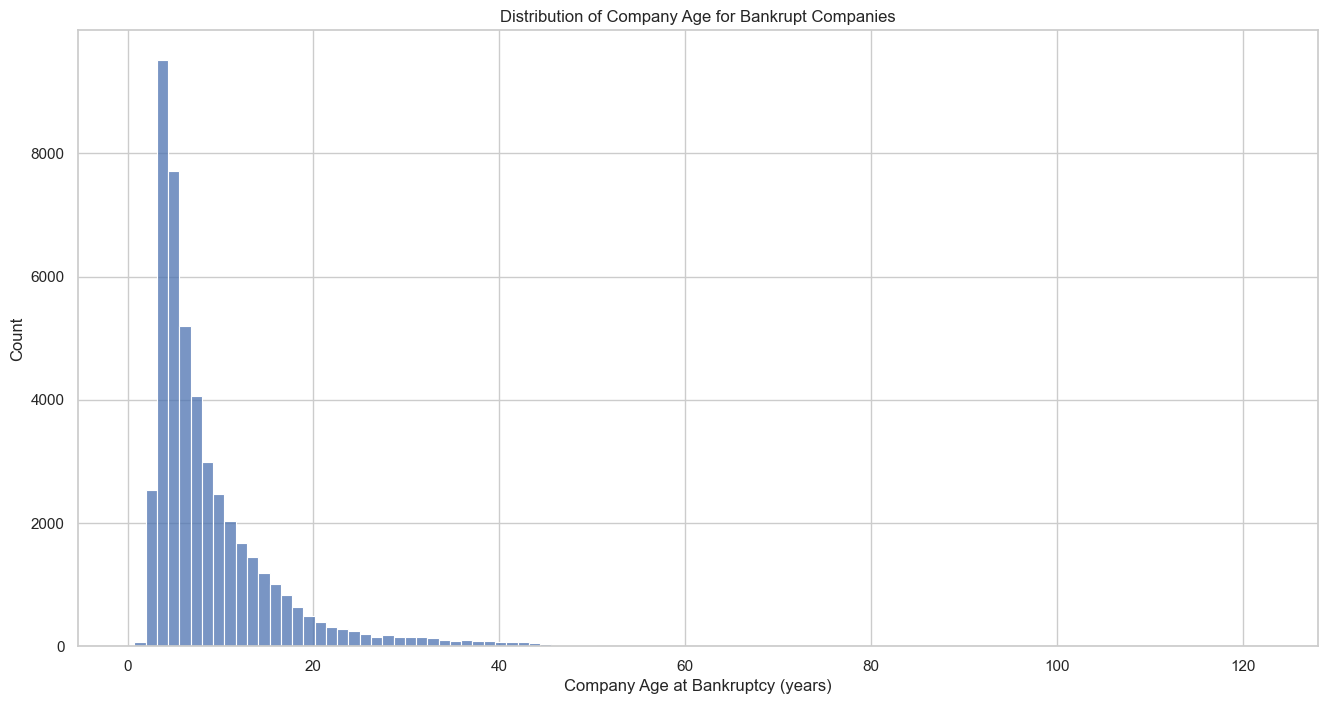

In [29]:
#plot the distribution of company age for bankrupt companies
plt.figure(figsize=(16, 8))
sns.histplot(df_bank_age['company_age'], bins=100)
plt.title('Distribution of Company Age for Bankrupt Companies')
plt.xlabel('Company Age at Bankruptcy (years)')
plt.ylabel('Count')
plt.show()

### 3.b Bankruptcy Company Age by Industry

In [30]:
#convert industries date to datetime
industries['FromDate'] = pd.to_datetime(industries['FromDate'])

#sort the dataframes
df_bank_age = df_bank_age.sort_values('bankrupt_date')
industries = industries.sort_values('FromDate')

#merge as of industries to get the industry code at the time of bankruptcy
df_bank_age_indu = pd.merge_asof(df_bank_age, industries, left_on='bankrupt_date', right_on='FromDate', by='CVR',direction='nearest')
df_bank_age_indu = df_bank_age_indu.drop(columns=['FromDate', 'ChangeType']).rename(columns={'NewValue': 'industry_code'})

In [31]:
#create column with first digit of industry code
df_bank_age_indu['short_industry_code'] = df_bank_age_indu['industry_code'].apply(lambda x: compute_industry_category(x))
df_bank_age_indu.sort_values('short_industry_code')
df_bank_age_indu['short_industry_code'] = df_bank_age_indu['short_industry_code'].astype(str)

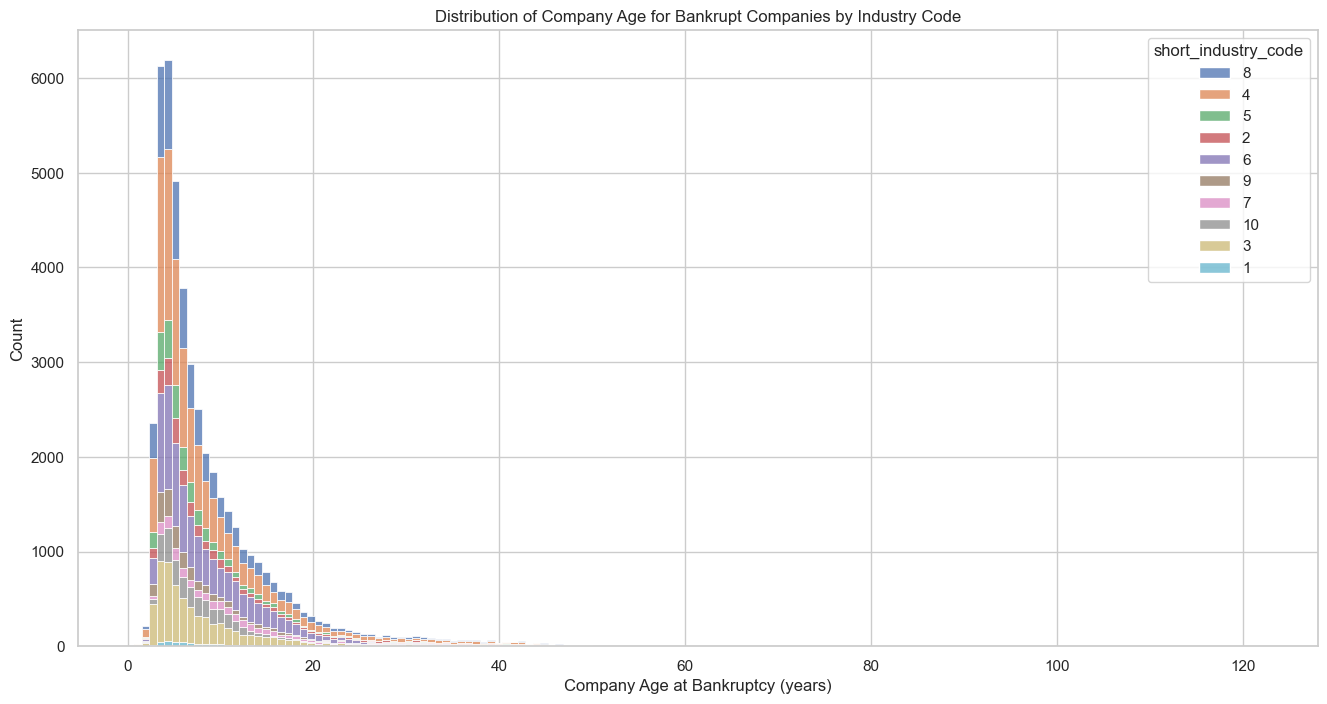

In [32]:
#make histogram of company age with bars stacked by industry code
plt.figure(figsize=(16, 8))
sns.histplot(df_bank_age_indu, x='company_age', hue='short_industry_code', bins=150, multiple='stack')
plt.title('Distribution of Company Age for Bankrupt Companies by Industry Code')
plt.xlabel('Company Age at Bankruptcy (years)')
plt.ylabel('Count')
plt.show()

## **4. Financials**

### Buffer

- livsforløb for konkursramte virk kontra “raske”
- antal medarbejder vs. finans tal
- bestyrelsesstørrelser, erfaringsudvikling
- viz for subset af grupper, store vs små virk fx



additional thoughts:

Some industries covary. Logistics have more bankruptcies if the whole production sector is down?

Years where the whole industry is down leads to more bankruptcies in the industry -duh?

## **6. Boards**

### 6.a Number of Entries in Years Prior to Bankruptcy

In [33]:
#load participants data
participants_folder = DATA_ROOT / "Tables" / "Participants"
participants_files = [file for file in os.listdir(participants_folder) if file.endswith('.csv')]
participants = pd.concat([pd.read_csv(os.path.join(participants_folder, file), index_col=0) for file in participants_files])

#convert participants date to datetime
participants['Date'] = pd.to_datetime(participants['Date'],errors='coerce')

In [34]:
#map management positions to PARTICIPANT_TYPE = ['BOARD_MEMBER', 'CEO']
management_map = {
    "BESTYRELSESMEDLEM": "BOARD_MEMBER",
    "DIREKTION": "C_LEVEL_EXECUTIVE",
    "DIREKTØR": "C_LEVEL_EXECUTIVE",
    "FORMAND": "BOARD_MEMBER",
    "ADM. DIR.": "C_LEVEL_EXECUTIVE",
    "NÆSTFORMAND": "BOARD_MEMBER",
    "BESTYRELSE": "BOARD_MEMBER",
    "SUPPLEANT": "BOARD_MEMBER"
}
participants['RelationType'] = participants['RelationType'].str.strip().str.upper()
participants['RelationType'] = participants['RelationType'].map(management_map)

#filter out the management positions
management = participants.loc[participants.RelationType.isin(['BOARD_MEMBER', 'C_LEVEL_EXECUTIVE'])]

#filter out companies
management = management.loc[management.ParticipantType != 'VIRKSOMHED']

In [35]:
#joon on bankrupcy date and cvr
management = management.merge(df_bankrupt[['CVR', 'bankrupt_date','bankrupt_type']], on='CVR', how='left')

In [36]:
#compute years to bankruptcy if there is a bankruptcy date otherwise nan
management['years_to_bankruptcy'] = (management['Date'] - management['bankrupt_date']).dt.days / 365

In [37]:
management_bankrupt = management.loc[management.years_to_bankruptcy.notnull()]
management_alive = management.loc[management.years_to_bankruptcy.isnull()]

In [38]:
#filter management bankrupt to only include entry and exits within 0-3 before bankruptcy
management_bankrupt = management_bankrupt.loc[(management_bankrupt.years_to_bankruptcy >= -3) & (management_bankrupt.years_to_bankruptcy <= 0)]

#compute helper column for is_entry if 'Participation' == 'entry'
management_bankrupt['is_entry'] = management_bankrupt['Participation'].apply(lambda x: x == 'entry')

#round years to bankruptcy to nearest integer
management_bankrupt['years_to_bankruptcy'] = management_bankrupt['years_to_bankruptcy'].round()

# group by cvr and years to bankruptcy and count the number of entries
management_bankrupt_grouped = management_bankrupt.groupby(['CVR', 'years_to_bankruptcy']).agg({'is_entry': 'sum'}).reset_index()

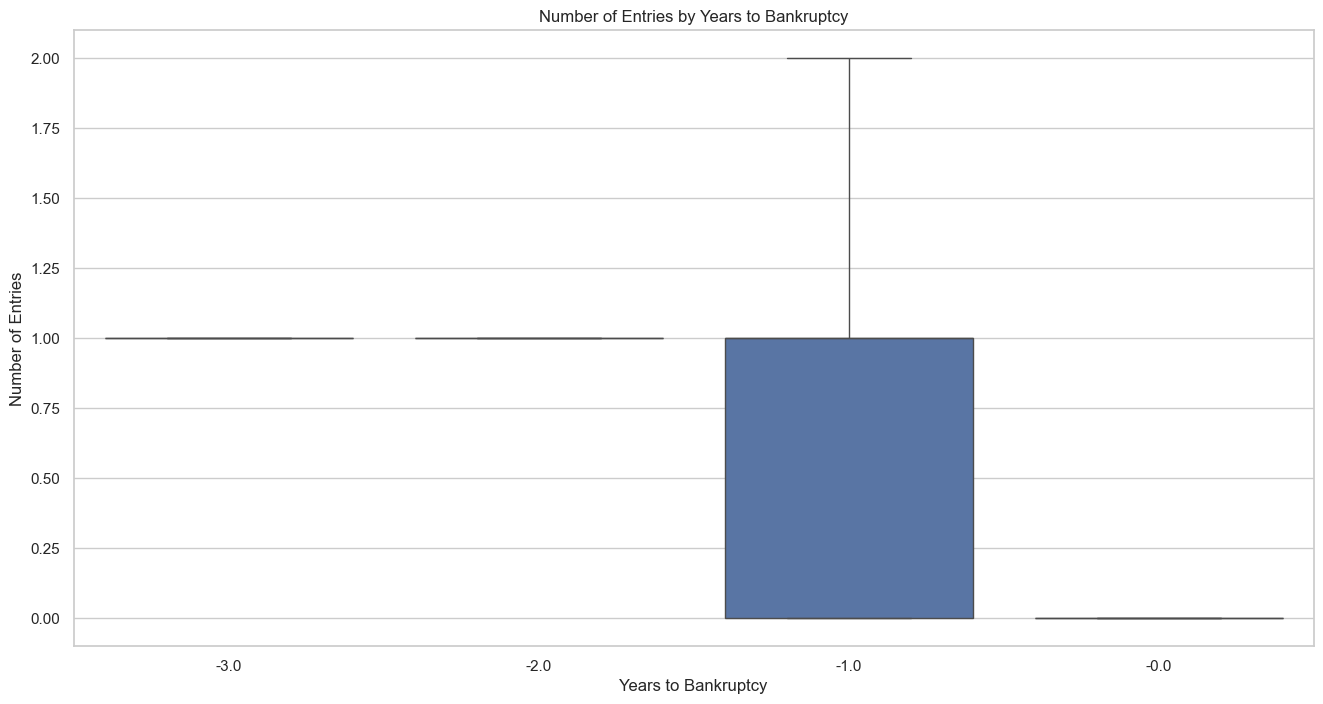

In [39]:
#create a boxplot of the number of entries by years to bankruptcy
plt.figure(figsize=(16, 8))
sns.boxplot(data=management_bankrupt_grouped, x='years_to_bankruptcy', y='is_entry',showfliers=False)
plt.title('Number of Entries by Years to Bankruptcy')
plt.xlabel('Years to Bankruptcy')
plt.ylabel('Number of Entries')
plt.show()

### 6.b Experince over time

In [40]:
# load experience data
experience_folder = DATA_ROOT / "interim" / "leadership"
experience_files = [file for file in os.listdir(experience_folder) if file.endswith('2023.parquet')]
experience = pd.concat([pd.read_parquet(os.path.join(experience_folder, file)) for file in experience_files])

In [41]:
#compute year
experience['FromDate'] = pd.to_datetime(experience['FromDate'])
experience['year'] = experience['FromDate'].dt.year

In [42]:
#group by cvr, year and relation type and count sum the collective experience
experience_grouped = experience.groupby(['CVR', 'year', 'RelationType']).agg({'Experience': 'sum'}).reset_index()

In [43]:
df_bankrupt['is_bankrupt'] = True

#join with df_bankrupt to only include companies that are bankrupt
experience_grouped = experience_grouped.merge(df_bankrupt[['CVR', 'is_bankrupt']], on='CVR', how='left')

In [44]:
#fill nan with False
experience_grouped['is_bankrupt'] = experience_grouped['is_bankrupt'].fillna(False)

/var/folders/18/tx_vvd811j166hznznnvx7sm0000gn/T/ipykernel_54696/3131378065.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  experience_grouped['is_bankrupt'] = experience_grouped['is_bankrupt'].fillna(False)


/opt/anaconda3/envs/ABA/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


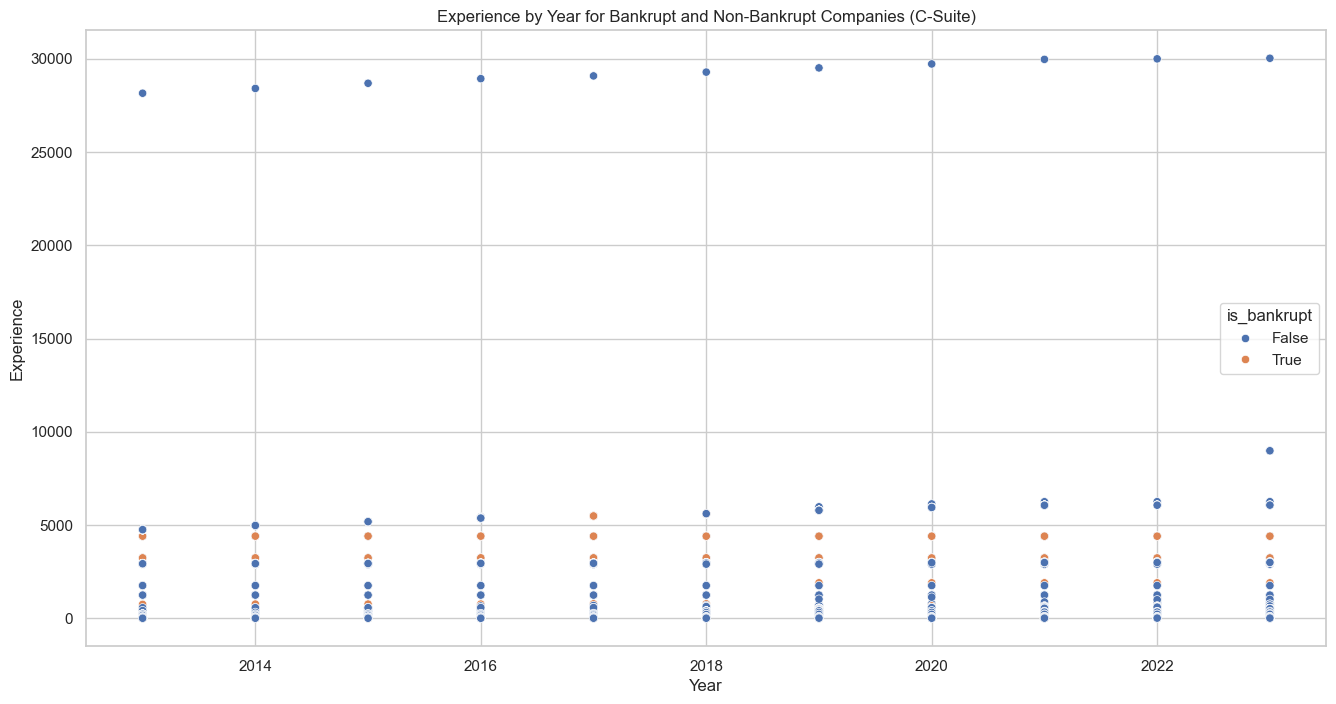

In [45]:
#create scatterplot of experience by year for bankrupt and non-bankrupt companies, color by is_bankrupt
plt.figure(figsize=(16, 8))
sns.scatterplot(data=experience_grouped.loc[experience_grouped.RelationType == 'C_LEVEL_EXECUTIVE'], x='year', y='Experience', hue='is_bankrupt')
plt.title('Experience by Year for Bankrupt and Non-Bankrupt Companies (C-Suite)')
plt.xlabel('Year')
plt.ylabel('Experience')
plt.show()

/opt/anaconda3/envs/ABA/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


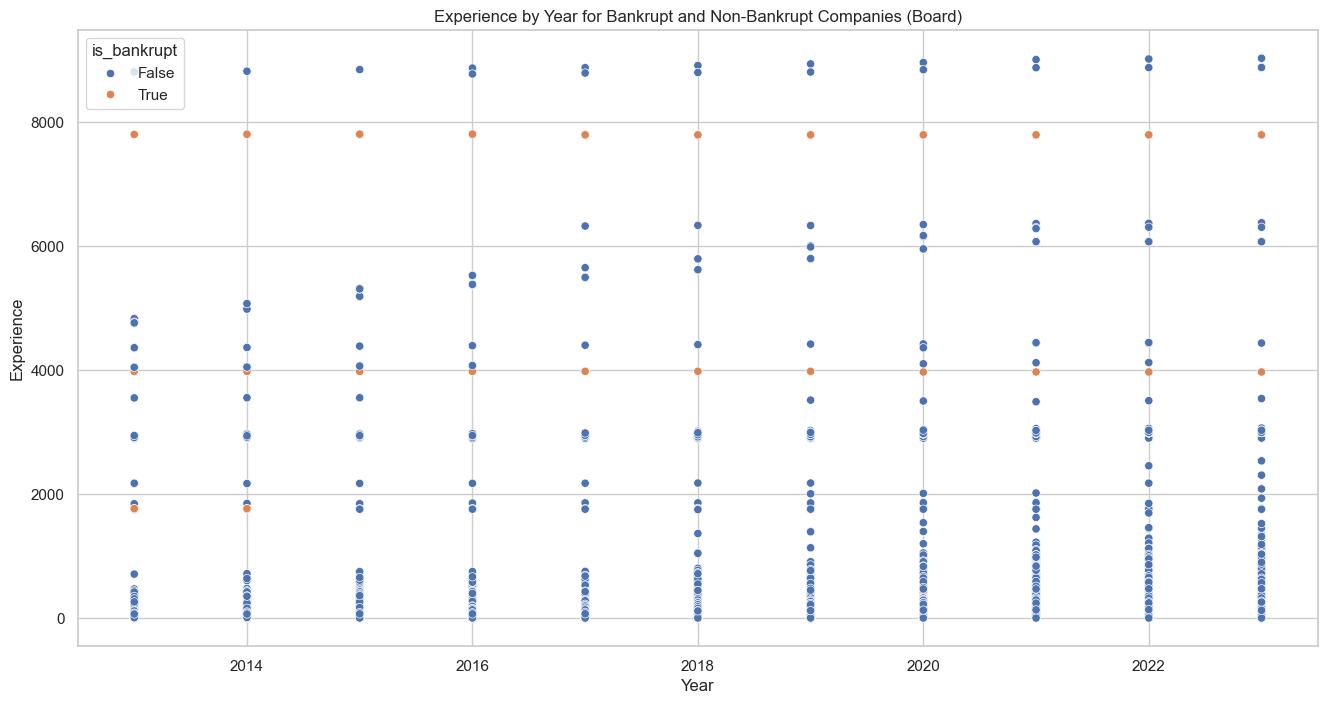

In [46]:
#create scatterplot of experience by year for bankrupt and non-bankrupt companies, color by is_bankrupt
plt.figure(figsize=(16, 8))
sns.scatterplot(data=experience_grouped.loc[experience_grouped.RelationType == 'BOARD_MEMBER'], x='year', y='Experience', hue='is_bankrupt')
plt.title('Experience by Year for Bankrupt and Non-Bankrupt Companies (Board)')
plt.xlabel('Year')
plt.ylabel('Experience')
plt.show()

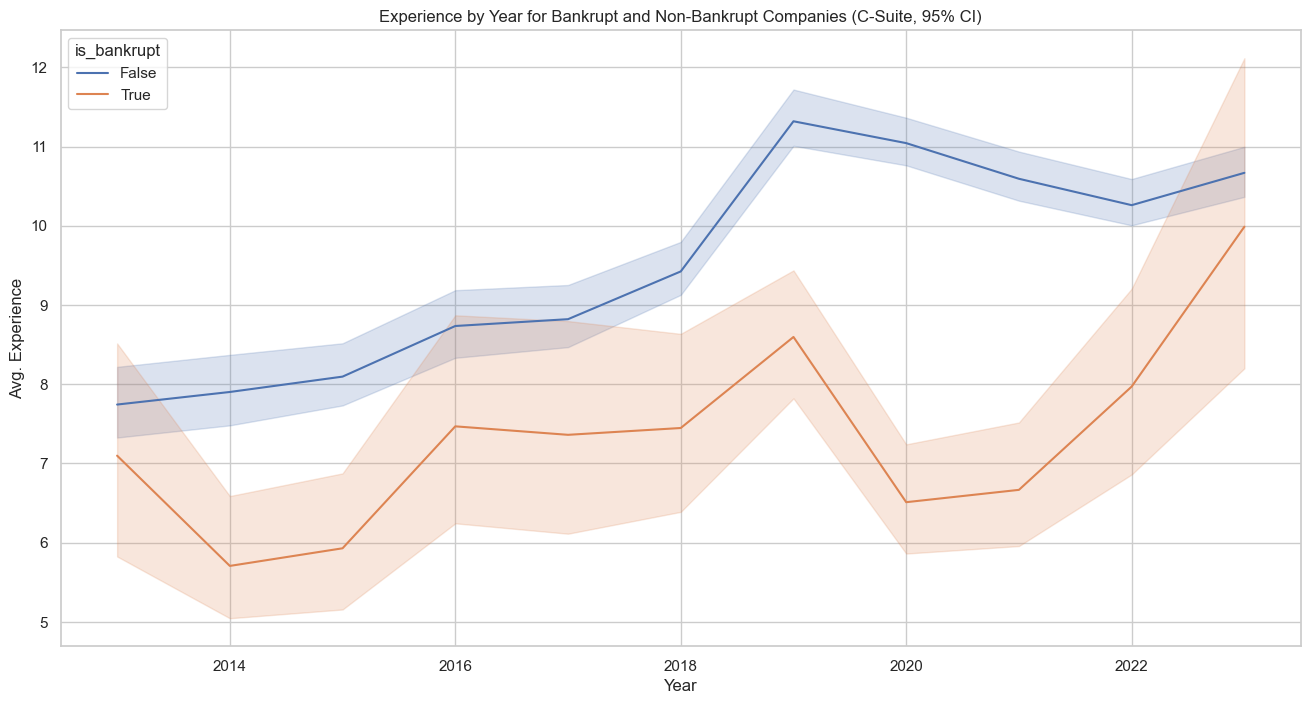

In [47]:
#line chart of experience by year per company, color line by bankrupt and non-bankrupt companies
plt.figure(figsize=(16, 8))
sns.lineplot(data=experience_grouped.loc[experience_grouped.RelationType == 'C_LEVEL_EXECUTIVE'], x='year', y='Experience', hue='is_bankrupt')
plt.title('Experience by Year for Bankrupt and Non-Bankrupt Companies (C-Suite, 95% CI)')
plt.xlabel('Year')
plt.ylabel('Avg. Experience')
plt.show()

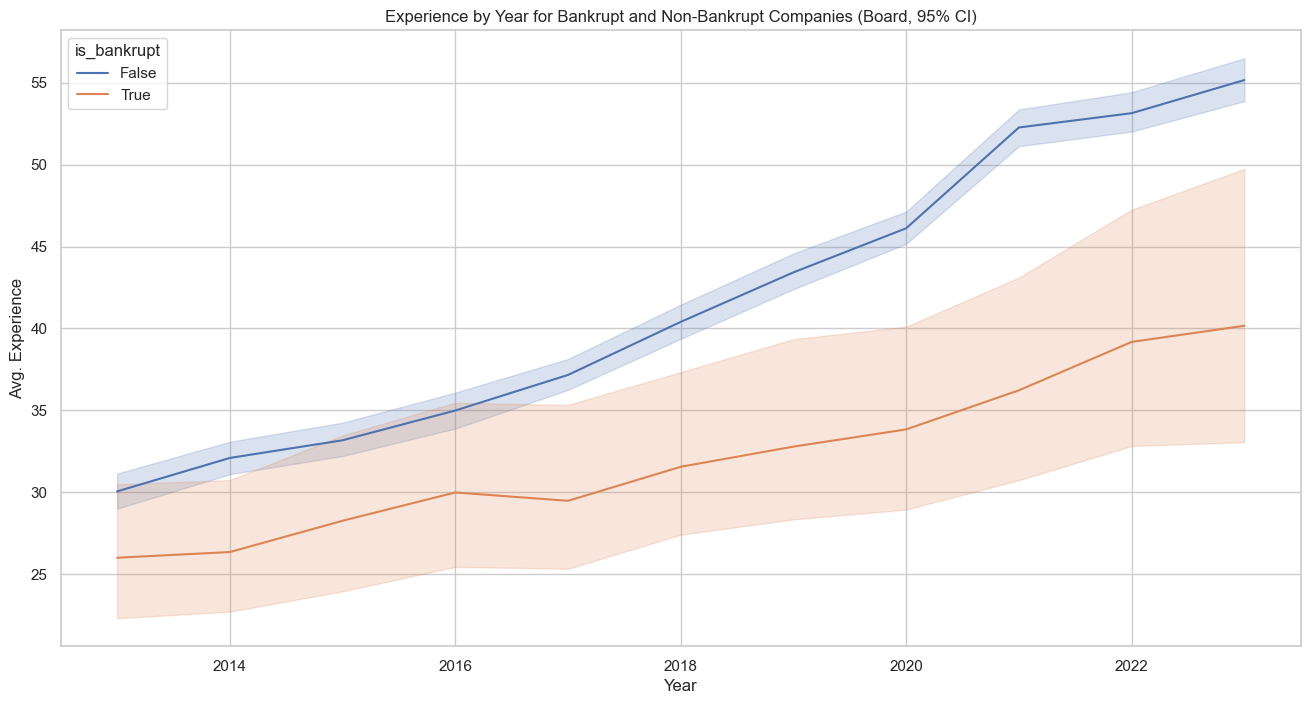

In [48]:
#line chart of experience by year per company, color line by bankrupt and non-bankrupt companies
plt.figure(figsize=(16, 8))
sns.lineplot(data=experience_grouped.loc[experience_grouped.RelationType == 'BOARD_MEMBER'], x='year', y='Experience', hue='is_bankrupt')
plt.title('Experience by Year for Bankrupt and Non-Bankrupt Companies (Board, 95% CI)')
plt.xlabel('Year')
plt.ylabel('Avg. Experience')
plt.show()

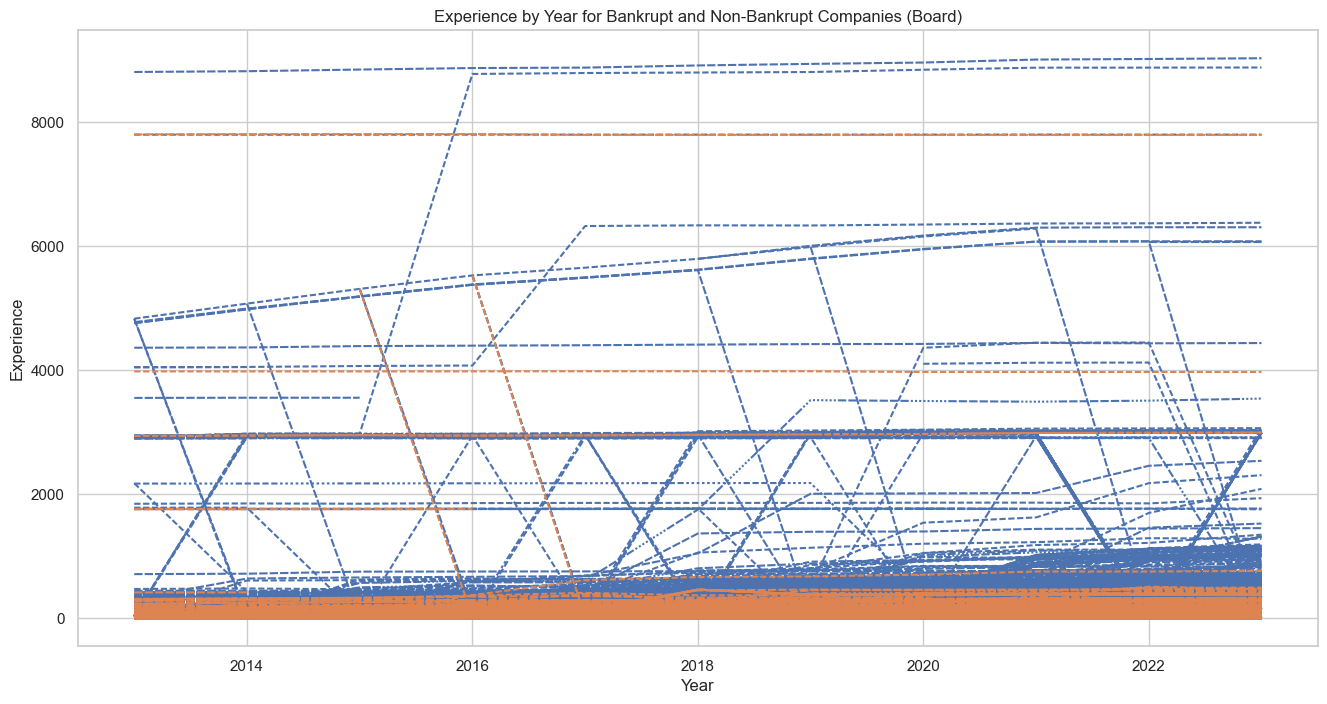

In [49]:
plt.figure(figsize=(16, 8))
sns.lineplot(data=experience_grouped.loc[experience_grouped.RelationType == 'BOARD_MEMBER'],
             x='year', y='Experience', hue='is_bankrupt', style='CVR', legend=False)
plt.title('Experience by Year for Bankrupt and Non-Bankrupt Companies (Board)')
plt.xlabel('Year')
plt.ylabel('Experience')
plt.show()

### 6.c Size of Board for Bankrupt vs. Alive Companies

In [50]:
#compute size of the board and c-suite for each company in each year
experience['size'] = 1
experience_grouped_size = experience.groupby(['CVR', 'year', 'RelationType']).agg({'size': 'sum'}).reset_index()

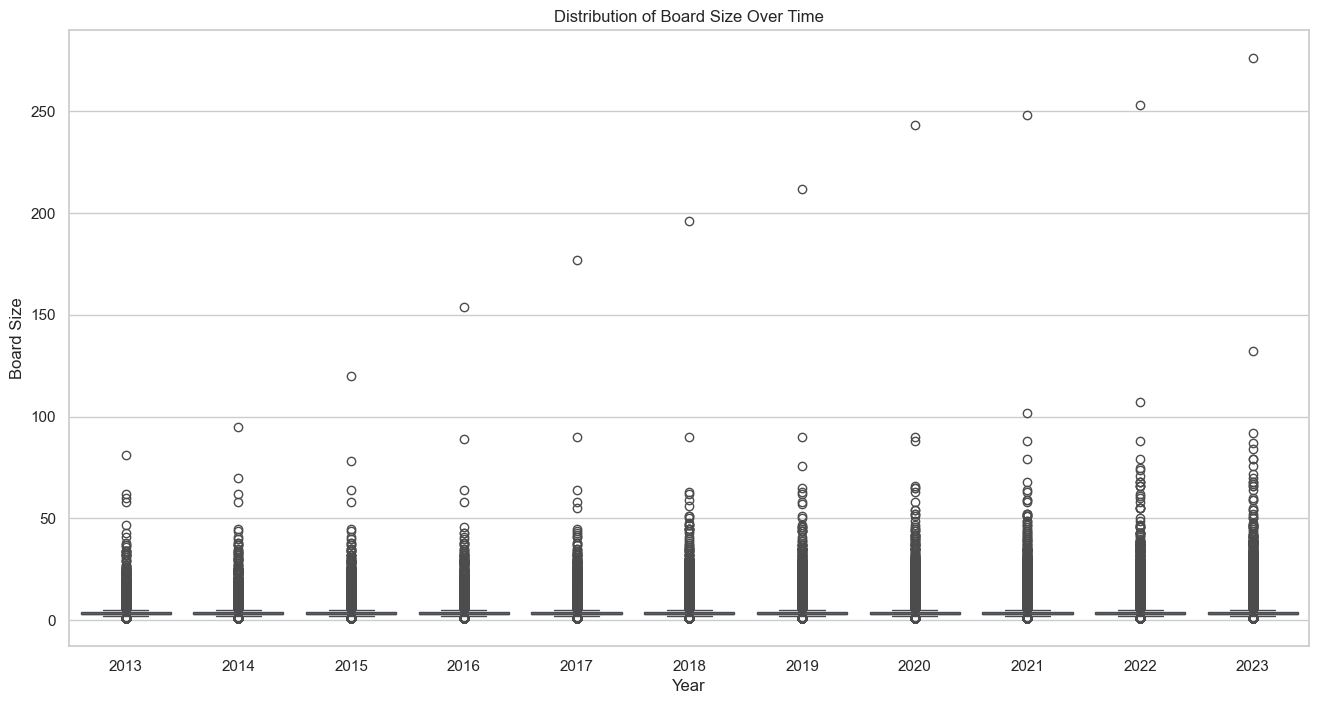

In [51]:
#plot distribution of board size as a boxplot
plt.figure(figsize=(16, 8))
sns.boxplot(data=experience_grouped_size.loc[experience_grouped_size.RelationType == 'BOARD_MEMBER'], x='year', y='size', showfliers=True)
plt.title('Distribution of Board Size Over Time')
plt.xlabel('Year')
plt.ylabel('Board Size')
plt.show()

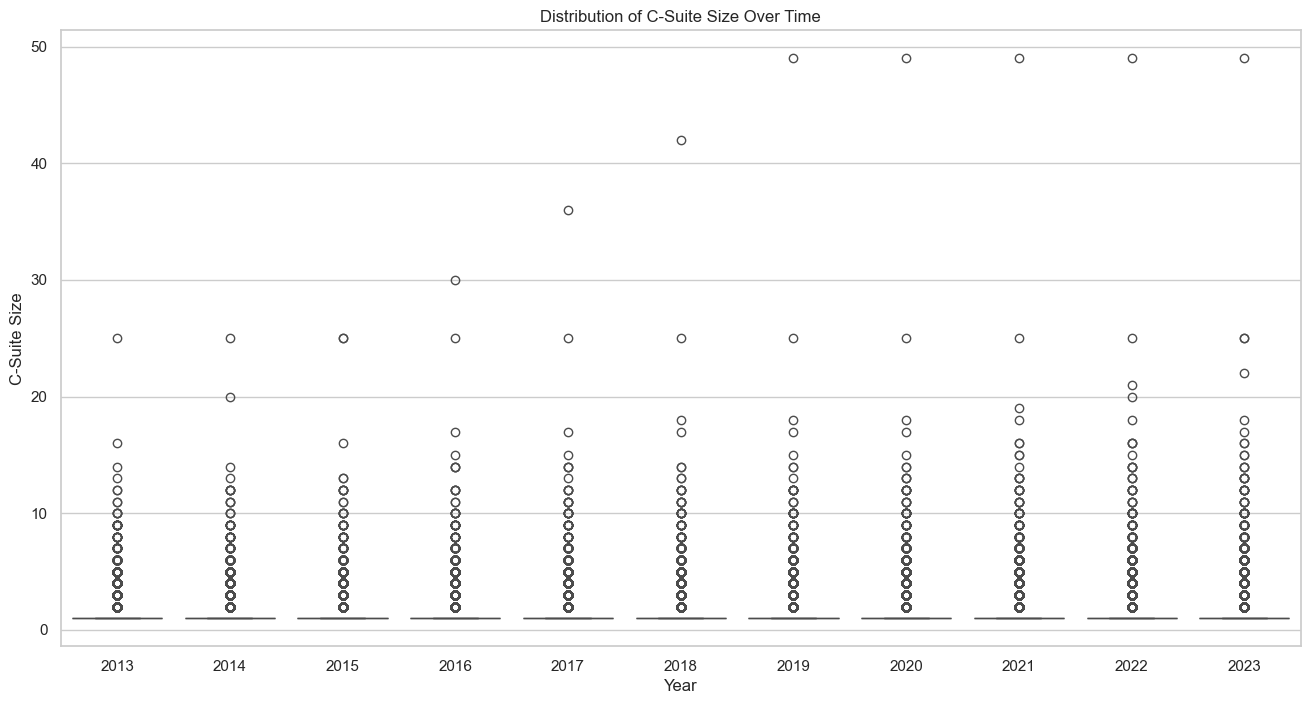

In [52]:
#plot distribution of board size as a boxplot
plt.figure(figsize=(16, 8))
sns.boxplot(data=experience_grouped_size.loc[experience_grouped_size.RelationType == 'C_LEVEL_EXECUTIVE'], x='year', y='size', showfliers=True)
plt.title('Distribution of C-Suite Size Over Time')
plt.xlabel('Year')
plt.ylabel('C-Suite Size')
plt.show()

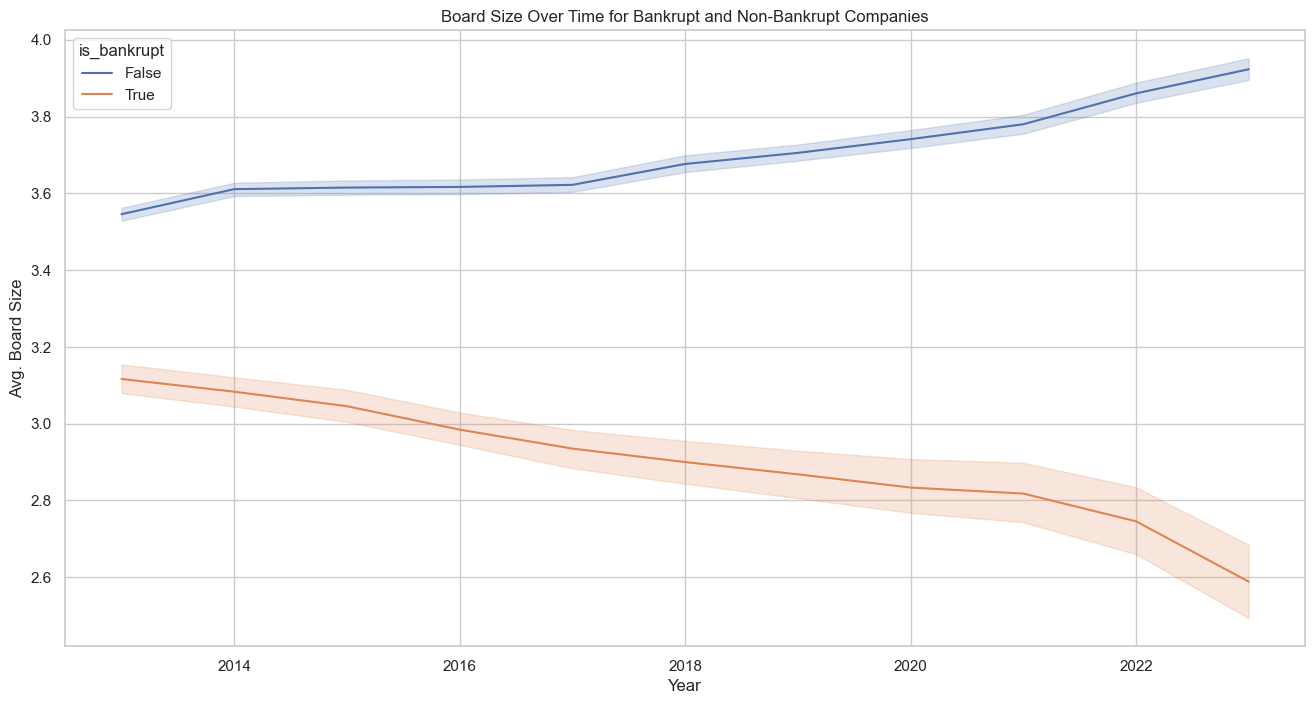

In [53]:
#line chart of board size over time color by bankrupt and non-bankrupt companies

experience_grouped_size['is_bankrupt'] = experience_grouped_size['CVR'].isin(df_bankrupt['CVR'])

plt.figure(figsize=(16, 8))
sns.lineplot(data=experience_grouped_size.loc[experience_grouped_size.RelationType == 'BOARD_MEMBER'], x='year', y='size', hue='is_bankrupt')
plt.title('Board Size Over Time for Bankrupt and Non-Bankrupt Companies')
plt.xlabel('Year')
plt.ylabel('Avg. Board Size')
plt.show()

## **9. Production Units**

In [54]:
#load production unit data
production_unit_folder = DATA_ROOT / "Tables" / "ProductionUnits"
production_unit_files = [file for file in os.listdir(production_unit_folder) if file.endswith('.csv')]
production_units = pd.concat([pd.read_csv(os.path.join(production_unit_folder, file), index_col=0) for file in production_unit_files])

In [55]:
#count number of production closures last 3 years before bankruptcy
production_units['Date'] = pd.to_datetime(production_units['Date'])
production_units['year'] = production_units['Date'].dt.year

production_units['is_bankrupt'] = production_units['CVR'].isin(df_bankrupt['CVR'])

#join on bankruptcy date
production_units = production_units.merge(df_bankrupt[['CVR', 'bankrupt_date']], on='CVR', how='left')

#compute years to bankruptcy
production_units['years_to_bankruptcy'] = (production_units['Date'] - production_units['bankrupt_date']).dt.days / 365
#round years to bankruptcy to nearest integer
production_units['years_to_bankruptcy'] = production_units['years_to_bankruptcy'].round()

In [59]:
test = production_units.loc[(production_units.years_to_bankruptcy >= -3) & (production_units.years_to_bankruptcy <= 0)]

In [60]:
test.loc[test.ChangeType == 'End']

,CVR,UnitNumber,Date,ChangeType,Municipality,Industry,year,is_bankrupt,bankrupt_date,years_to_bankruptcy
17,30700236,1013415052,2021-08-30,End,265.0,454200.0,2021,True,2021-08-30,0.0
27,31180961,1014114560,2021-04-12,End,630.0,999999.0,2021,True,2021-04-12,0.0
43,27912400,1010630122,2021-09-30,End,565.0,514210.0,2021,True,2021-09-30,0.0
69,30810597,1013562233,2022-08-30,End,101.0,741490.0,2022,True,2022-03-30,0.0
93,30494482,1013178824,2022-03-08,End,157.0,980000.0,2022,True,2022-03-08,0.0
...,...,...,...,...,...,...,...,...,...,...
742080,39940442,1024041227,2023-09-18,End,420.0,642020.0,2023,True,2023-09-18,0.0
742224,39886782,1023981420,2023-09-18,End,480.0,642020.0,2023,True,2023-09-18,0.0
742498,40218556,1024360063,2024-04-29,End,813.0,642020.0,2024,True,2023-11-06,0.0
742742,37407445,1021103906,2021-12-13,End,223.0,999999.0,2021,True,2021-12-13,0.0


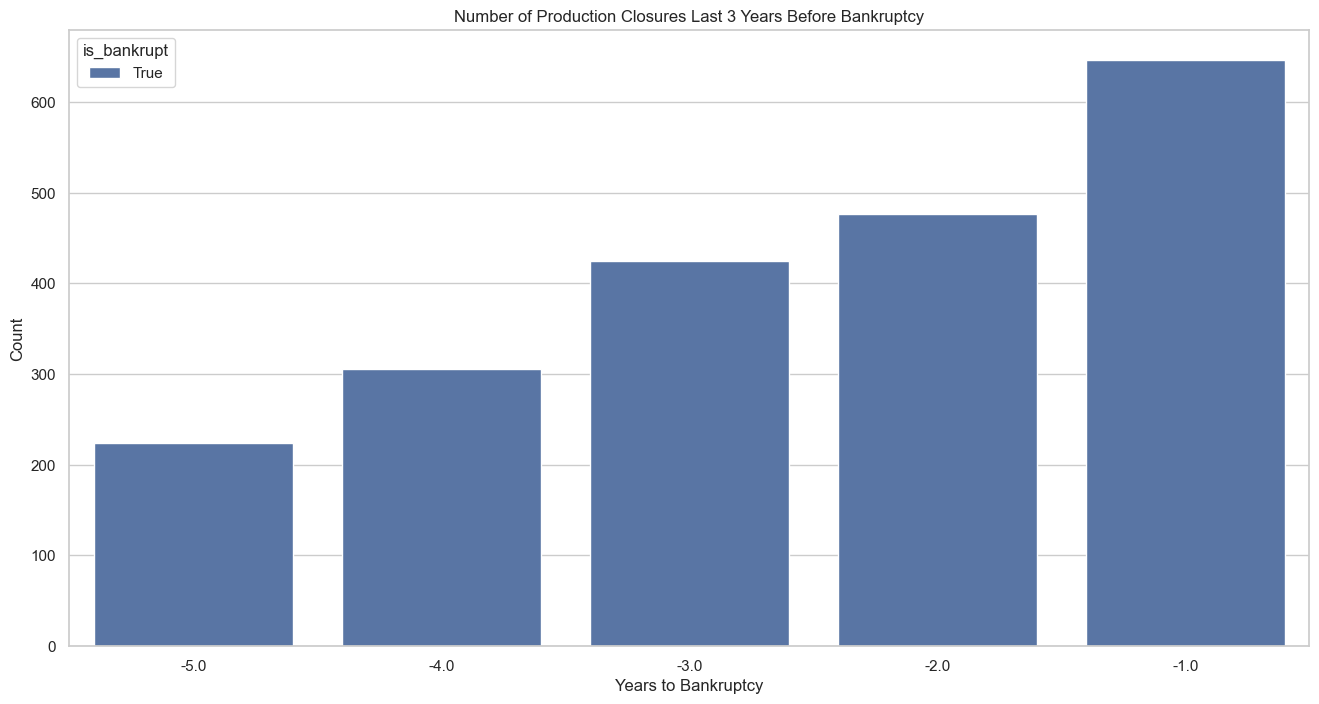

In [67]:
count_end_plot = production_units.loc[(production_units.years_to_bankruptcy >= -5) & (production_units.years_to_bankruptcy < 0)]
count_end_plot = count_end_plot.loc[count_end_plot.ChangeType == 'End']

#plot number of production closures last 3 years before bankruptcy
plt.figure(figsize=(16, 8))
sns.countplot(data=count_end_plot, x='years_to_bankruptcy', hue='is_bankrupt')
plt.title('Number of Production Closures Last 3 Years Before Bankruptcy')
plt.xlabel('Years to Bankruptcy')
plt.ylabel('Count')
plt.show()

In [71]:
#group by cvr and years to bankruptcy and count sum number of production closures
count_end_plot_box = count_end_plot.groupby(['CVR', 'years_to_bankruptcy']).size().reset_index(name='count')

In [73]:
count_end_plot_box

,CVR,years_to_bankruptcy,count
0,10010268,-2.0,1
1,10048427,-1.0,1
2,10096189,-3.0,1
3,10096189,-2.0,3
4,10127890,-1.0,3
...,...,...,...
1435,84940828,-2.0,1
1436,86111810,-2.0,1
1437,87199312,-1.0,2
1438,87222128,-1.0,1


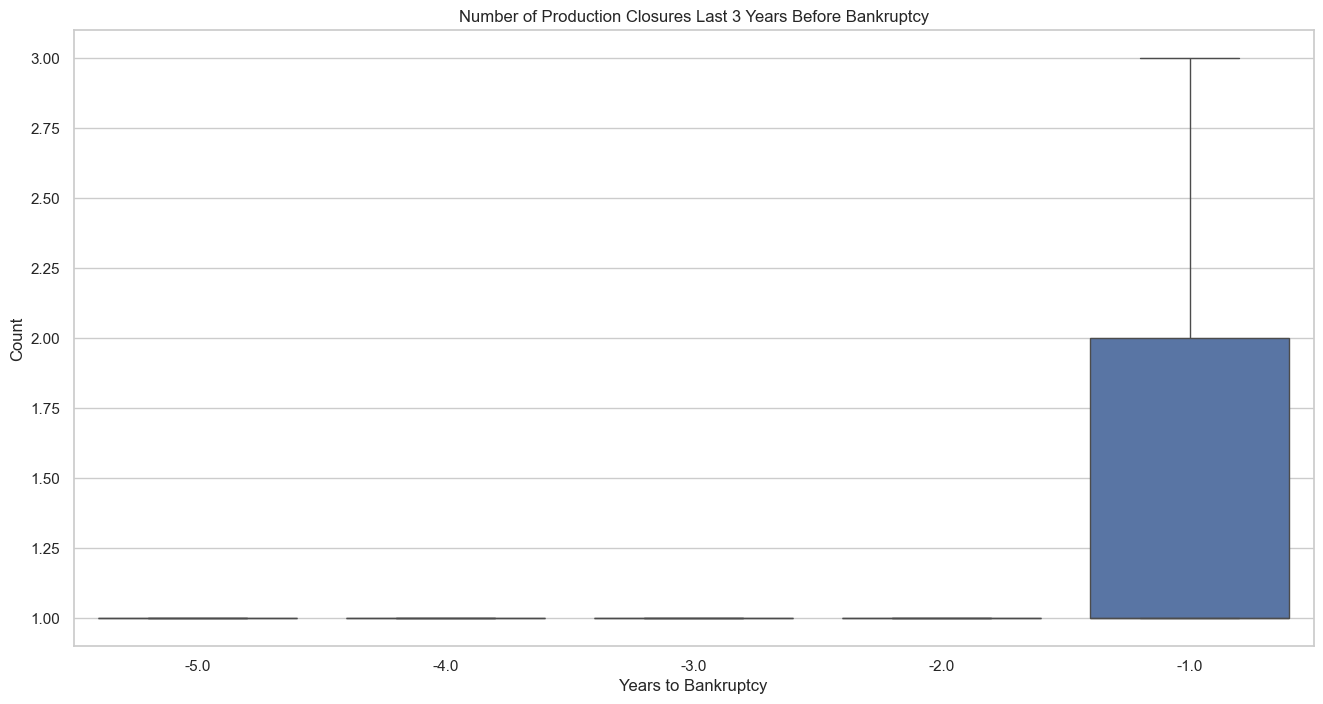

In [75]:
#plot boxplot of production closures last 3 years before bankruptcy
plt.figure(figsize=(16, 8))
sns.boxplot(data=count_end_plot_box, x='years_to_bankruptcy', y='count',showfliers=False)
plt.title('Number of Production Closures Last 3 Years Before Bankruptcy')
plt.xlabel('Years to Bankruptcy')
plt.ylabel('Count')
plt.show()